In [5]:
import pandas as pd

# Read the CSV file
file_path = 'DataDummyPsikografi_2500_v1.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe
print(df.head())


                                  Produk sering beli          Saluran belanja  \
0  Buku Non-Fiksi (Pengembangan Diri, Bisnis, dll...  Toko alat tulis lainnya   
1                                 Komik/Novel Grafis    Aplikasi Gramedia.com   
2                                      Alat Olahraga            Toko Gramedia   
3                            Mainan/Collectible item  Toko alat tulis lainnya   
4  Jurnal/Perencana (Planner); Buku Non-Fiksi (Pe...    Aplikasi Gramedia.com   

                            Motivasi utama pembelian  \
0           Kado atau hadiah; Hiburan atau relaksasi   
1  Untuk mengekspresikan kreativitas; Mendukung h...   
2                               Menambah pengetahuan   
3  Kebutuhan pekerjaan/sekolah (alat tulis, perle...   
4  Untuk mengekspresikan kreativitas; Sebagai ben...   

                                                Hobi  \
0       Bermain game (offline/online); Bermain musik   
1  Belanja online/offline; Bermain game (offline/...   
2  Meluk

In [6]:
import pandas as pd
from itertools import product

# --- Step 2: Define mapping dictionaries ---
produk_map = {
    'Novel Fiksi': 'Novel Fiksi',
    'Buku Non-Fiksi (Pengembangan Diri, Bisnis, dll.)': 'Buku Non-Fiksi',
    'Buku Pelajaran/Edukasi (Termasuk Latihan Soal, Kamus)': 'Edukasi',
    'Komik/Novel Grafis': 'Komik',
    'Buku Anak': 'Buku Anak',
    'Perlengkapan Seni/Kreatif': 'Alat Seni',
    'Alat Musik': 'Alat Seni',
    'Alat Tulis Umum (Kantor/Sekolah)': 'Alat Kantor/Sekolah',
    'Jurnal/Perencana (Planner)': 'Alat Kantor/Sekolah',
    'Perlengkapan Kantor atau Sekolah': 'Alat Kantor/Sekolah',
    'Mainan/Collectible item': 'Sport & mainanan',
    'Alat Olahraga': 'Sport & mainanan'
}

hobi_map = {
    'Membaca buku atau majalah': 'Literasi',
    'Menulis (diari, blog, atau lainnya)': 'Literasi',
    'Melukis atau menggambar': 'Seni',
    'Bermain musik': 'Seni',
    'Bermain game (offline/online)': 'Aktivitas Rekreasional',
    'Olahraga': 'Aktivitas Rekreasional',
    'Menghadiri acara budaya atau edukasi': 'Aktivitas Rekreasional',
    'Belanja online/offline': 'Lifestyle',
    'Travelling': 'Lifestyle'
}

minat_map = {
    'Buku fiksi (novel, komik, buku anak)': 'edukasi',
    'Buku non-fiksi (pengembangan diri, sejarah, agama)': 'edukasi',
    'Buku Edukasi (Buku Teks, Latihan Soal, Kamus)': 'edukasi',
    'Alat Musik & kesenian': 'Alat Seni',
    'Mainan': 'Self Wear',
    'Alat Olahraga': 'Self Wear',
    'Alat Tulis kantor atau sekolah': 'Daily needs',
    'Kesehatan dan Kecantikan': 'Self Wear'
}

# --- Step 3: Define columns to explode ---
multi_cols = ['Produk sering beli', 'Motivasi utama pembelian', 'Hobi', 'Minat']

# Add ID column
df.insert(0, 'ID', df.index + 1)

# Identify non-multi-answer columns
static_cols = [col for col in df.columns if col not in multi_cols]

# --- Step 4: Explode rows via Cartesian product ---
exploded_rows = []

for _, row in df.iterrows():
    # Split multi-answers by semicolon
    multi_values = {
        col: [item.strip() for item in str(row[col]).split(';')] if pd.notna(row[col]) else ['']
        for col in multi_cols
    }
    
    # Cartesian combinations
    combinations = product(*[multi_values[col] for col in multi_cols])
    
    for combo in combinations:
        new_row = {col: row[col] for col in static_cols}
        for col, val in zip(multi_cols, combo):
            new_row[col] = val
        exploded_rows.append(new_row)

df_exploded = pd.DataFrame(exploded_rows)

# --- Step 5: Apply mappings ---
df_exploded['Produk sering beli'] = df_exploded['Produk sering beli'].map(produk_map).fillna(df_exploded['Produk sering beli'])
df_exploded['Hobi'] = df_exploded['Hobi'].map(hobi_map).fillna(df_exploded['Hobi'])
df_exploded['Minat'] = df_exploded['Minat'].map(minat_map).fillna(df_exploded['Minat'])

# --- Step 6: Reorder and save ---
ordered_cols = ['ID'] + [col for col in df.columns if col != 'ID']
df_exploded = df_exploded[ordered_cols]

output_file = 'DataDummyPsikografi_2500_Exploded_Labeled.csv'
df_exploded.to_csv(output_file, index=False)

print(f"✅ Labeled and exploded data saved to: {output_file}")


✅ Labeled and exploded data saved to: DataDummyPsikografi_2500_Exploded_Labeled.csv


In [7]:
import pandas as pd
from collections import Counter
from itertools import product

# Load exploded and labeled dataset
df = pd.read_csv('DataDummyPsikografi_2500_Exploded_Labeled.csv')

# Columns to score
group_cols = [
    'Produk sering beli',
    'Motivasi utama pembelian',
    'Hobi',
    'Minat'
]

# Columns to retain (static fields)
static_cols = [col for col in df.columns if col not in group_cols]

# To hold results
all_combination_rows = []

# Group by respondent (ID)
for id_val, group in df.groupby('ID'):
    label_sets = {}

    for col in group_cols:
        # Count frequency of each answer
        counts = Counter(group[col].dropna())
        if counts:
            max_count = max(counts.values())
            top_labels = sorted([label for label, freq in counts.items() if freq == max_count])
            label_sets[col] = top_labels
        else:
            label_sets[col] = ['']

    # Get static data from the first row of the group
    static_data = group.iloc[0][static_cols].to_dict()

    # Create Cartesian product of dominant values
    combos = product(*[label_sets[col] for col in group_cols])

    for combo in combos:
        row = static_data.copy()  # start with static fields
        for col, val in zip(group_cols, combo):
            row[col] = val  # insert scored values
        all_combination_rows.append(row)

# Convert to DataFrame
# Convert to DataFrame
df_combined = pd.DataFrame(all_combination_rows)

# Restore original column order
original_order = df.columns.tolist()
df_combined = df_combined[original_order]

# Save result
df_combined.to_csv('DataDummyPsikografi_2500_Scored_Combinations_WithStatic.csv', index=False)

print("✅ Scored combinations saved, with columns in original order.")


✅ Scored combinations saved, with columns in original order.


Elbow suggests k = 7
Best silhouette score at k = 2


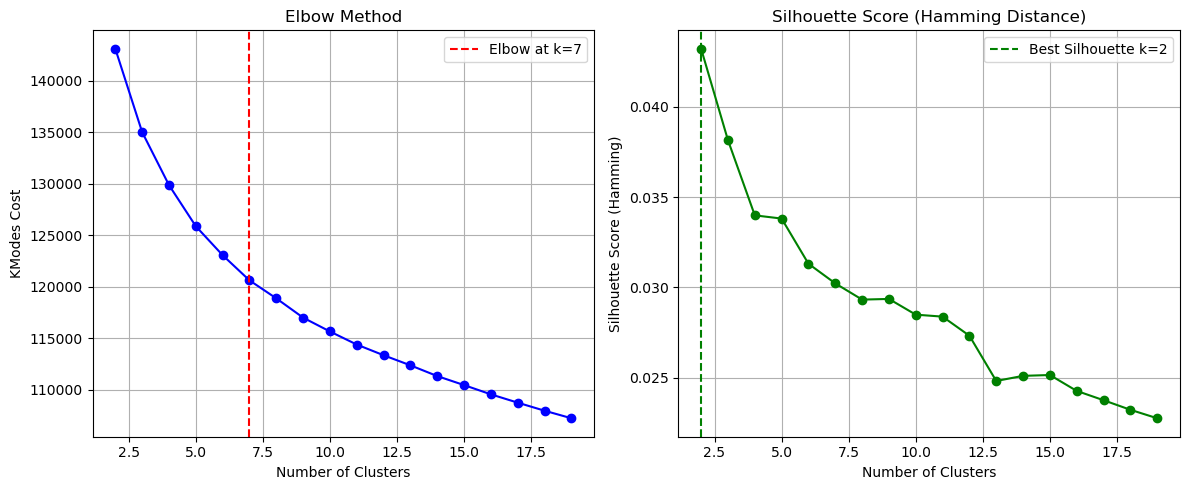

In [9]:
import pandas as pd
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from kneed import KneeLocator
import matplotlib.pyplot as plt

# 1) Load dataset and drop ID
df = pd.read_csv('DataDummyPsikografi_2500_Scored_Combinations_WithStatic.csv')
X_raw = df.drop(columns=['ID'])

# 2) Convert categorical strings to numeric codes
X = X_raw.apply(lambda col: col.astype('category').cat.codes)

# 3) Precompute Hamming distance matrix
D = pairwise_distances(X, metric='hamming')

# 4) Clustering and evaluation
Ks = range(2, 20)
costs = []
sil_scores = []

for k in Ks:
    km = KModes(n_clusters=k, init='Cao', n_init=5, random_state=42, verbose=0)
    labels = km.fit_predict(X_raw)  # Feed original (non-encoded) data to KModes
    costs.append(km.cost_)
    
    # Use encoded data for silhouette (Hamming)
    sil = silhouette_score(D, labels, metric='precomputed')
    sil_scores.append(sil)

# 5) Determine optimal k
elbow_k = KneeLocator(Ks, costs, curve='convex', direction='decreasing').elbow
best_sil_k = Ks[sil_scores.index(max(sil_scores))]

print(f"Elbow suggests k = {elbow_k}")
print(f"Best silhouette score at k = {best_sil_k}")

# 6) Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(Ks, costs, 'bo-')
if elbow_k: plt.axvline(elbow_k, color='red', linestyle='--', label=f'Elbow at k={elbow_k}')
plt.xlabel('Number of Clusters')
plt.ylabel('KModes Cost')
plt.title('Elbow Method')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Ks, sil_scores, 'go-')
plt.axvline(best_sil_k, color='green', linestyle='--', label=f'Best Silhouette k={best_sil_k}')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score (Hamming)')
plt.title('Silhouette Score (Hamming Distance)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
import pandas as pd
from kmodes.kmodes import KModes

# Optional: install tabulate for nicer console output
try:
    from tabulate import tabulate
    TABULATE_AVAILABLE = True
except ImportError:
    TABULATE_AVAILABLE = False

# --- Step 1: Load and prepare data ---
df = pd.read_csv('DataDummyPsikografi_2500_Scored_Combinations_WithStatic.csv')
X_raw = df.drop(columns=['ID'])

# --- Step 2: KModes clustering ---
k_final = 5
km = KModes(n_clusters=k_final, init='Cao', n_init=5, random_state=42, verbose=1)
labels = km.fit_predict(X_raw)

# --- Step 3: Assign labels back to DataFrame ---
df['Cluster'] = labels

# --- Step 4: Create cluster profile table ---
categorical_columns = X_raw.columns
profiles = []

for cluster_id in sorted(df['Cluster'].unique()):
    cluster_data = df[df['Cluster'] == cluster_id]
    profile = {'Cluster': cluster_id, 'Count': len(cluster_data)}
    
    for col in categorical_columns:
        mode_val = cluster_data[col].mode()[0]
        freq = (cluster_data[col] == mode_val).mean()
        profile[col] = f"{mode_val} ({freq:.1%})"
    
    profiles.append(profile)

profile_df = pd.DataFrame(profiles)

# --- Step 5: Pretty print the profile table ---
print("\n✅ Cluster Profiles (k = 5):\n")

if TABULATE_AVAILABLE:
    print(tabulate(profile_df, headers='keys', tablefmt='grid', showindex=False))
else:
    # fallback formatting
    print(profile_df.to_string(index=False))

# Optional: Save to CSV
profile_df.to_csv('Cluster_Profiles_K5_2500.csv', index=False)
df.to_csv('DataPsikografi_with_Clusters_2500.csv', index=False)


Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 125866.0

✅ Cluster Profiles (k = 5):

+-----------+---------+-----------------------------+-------------------------------------------+-----------------------------------------------------------------------+--------------------------------+-------------------+-------------------------------------------------------------------------+----------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------+
|   Cluster |   Count | Produk sering beli          | Saluran belanja                           | Motivasi utama pembelian                                              | Hobi                      